### Task Description:
You might have heard of the 9€ ticket that should be available in Germany from June until August. With this ticket, you are able to take regional trains and busses within Germany for 9€ per month. You're taking the chance and plan a city trip through Germany. Since you don't want to spend too much time in the trains to have more time in the cities, you want to optimize your traveling route. 

Specifically, you want to visit the following cities: 

**Osnabrück, Münster, Köln, München, Hamburg, Berlin, Hannover, Karlsruhe, Leipzig, Düsseldorf,Kassel, Cottbus, Bremen, Nürnberg, Saarbrücken**

For task simplicity, we assume that:
1. there are direct connections between all cities.
2. the distance between the cities is a valid indicator for the required travel time.

Of course, both assumptions might not be true in the real world.

### Task 1: The Ant Colony System
In the presentation, you have seen how Ant System can be used to solve the TSP. Now we want to use **Ant Colony System** instead of **Ant System**. It has some differences in the update of the phenomone trail, please read more on the [Ant Colony System](http://www.scholarpedia.org/article/Ant_colony_optimization#Ant_colony_system).

In [1]:
from itertools import count
from graph import *
from time import time
import random

In [18]:
class Ant:
    def __init__(self, graph, neighbors, valid, alpha=1, beta=1):
        """
        An ant is supposed to travel within a graph, visiting all nodes exactly once.
        :param graph: graph in which the ant is traveling
        :param neighbors: function that returns the neighbours of the node the ant currently is on
        :param valid: True once an ant has finished its solution
        :param alpha: importance of pheromone quantity
        :param beta: importance of heuristic information
        """
        self.graph = graph
        self.neighbors = lambda n: neighbors(self, n)
        self.valid = lambda: valid(self)
        self.alpha = alpha
        self.beta = beta
        self.reset()

    def __contains__(self, other):
        """
        Allows to test, whether a given ... is contained in either the nodes or edges within the current path.
        :param other: # TODO
        :return: True if ... already is in the path (either as a node or edge), False otherwise
        """
        if isinstance(other, Node):
            return other in self.path_nodes
        elif isinstance(other, Edge):
            return other in self.path_edges
        else:
            return False

    def reset(self):
        """
        Resets the current 'status' of an ant, i.e. ant is initialized on a random node within the graph and has not
        travelled yet.
        :return: ---
        """
        self.travel_dist = 0  # distance travelled
        self.node = random.choice(self.graph)  # current node on which the ant resides
        self.path_nodes = [self.node]  # current path of ant described through nodes
        self.path_edges = []  # current path of the ant described through edges

    def step(self):
        """
        Performs the next step of the ant, choosing the next node based on transition probabilities and adds the node
        and edges to the current path information.
        :return: True if a next step was performed, False otherwise
        """
        # Get the transition options and probabilities
        nodes, probabilities = self.transitions()

        # Stop if no nodes are to be visited anymore
        if not nodes:
            return False

        # Select a new node based on the provided probabilities and save the new node and the respective edge in the
        # path of the ant
        node = random.choices(nodes, weights=probabilities)[0]
        edge = self.graph[self.node, node]
        self.path_nodes.append(node)
        self.path_edges.append(edge)
        self.travel_dist += edge.value  # Update the total travelled distance of this ant
        self.node = node  # Update the current node
        return True

    def transitions(self):
        """
        Performs the calculations to receive information which nodes can be visited next with which probabilities.
        :return nodes: nodes that can be visited from the current node
        :return rho/ np.sum(rho): probabilities that the respective node is the next visited node
        """
        # For all nodes the current node is connected to, get the heuristic information and pheromone value for the
        # respective edge
        nodes, heuristic, pheromone = [], [], []
        for node in self.node:
            if self.neighbors(node):
                edge = self.graph[self.node, node]
                nodes.append(node)
                heuristic.append(edge.heuristic)
                pheromone.append(edge.pheromone)

        # Perform the calculations to receive the probabilities to determine the next node
        eta = np.array(heuristic)
        tau = np.array(pheromone)
        rho = tau ** self.alpha * eta ** self.beta  # TODO this is not the same rho as in the AntColony, right? Please rename this according to your preference
        return nodes, rho/np.sum(rho)


In [41]:
class AntColony:
    def __init__(self, n_ants, graph, rho=0.1, alpha=1, beta=1,
                 neighbors=lambda a, n: len(a.graph) > len(a.path_nodes) and n not in a.path_nodes 
                                     or len(a.graph) == len(a.path_nodes) and n == a.path_edges[0].source,
                 valid=lambda a: len(a.path_nodes) == len(a.graph) + 1, minmax=False):
        """
        An ant colony consists of a given number of ants, a graph in which the ants travel and parameter information on
        the algorithm: rho, alpha, and beta.
        :param n_ants: Number of ants within the colony
        :param graph: Graph with a problem to solve
        :param rho: Evaporation rate
        :param alpha: importance of pheromone quantity
        :param beta: importance of heuristic information
        :param neighbors: a function how the neighbours of a node are defined
        :param valid: a function that determines if ants have found a valid solution
        """
        self.n_ants = n_ants
        self.graph = graph
        self.rho = rho
        self.alpha = alpha
        self.beta = beta
        ## Add your code here
        self.graph.edges.heuristic = 1 / (self.graph.edges.value + 0.00001)  # TODO avoid potential division by zero
        self.minmax = minmax
        self.max, self.min = 1., 0.006
        self.ants = [Ant(self.graph, neighbors, valid, alpha, beta) for _ in range(n_ants)]
        self.node = random.choice(graph)
        self.graph.edges.pheromone = 1.0

    def __call__(self, N=None):
        """
        Executes the ant colony optimization algorithm.
        :param N: number of iterations
        :return: # TODO
        """
        start = time()
        iterator = count() if N is None else range(N)
        self.min_length = float('inf')
        self.min_path = None
        min_length_tracker, counter, i = 10000, 0, 0
        for _ in iterator:
            # Reset all ants at the beginning of each iteration
            for ant in self:
                ant.reset()
            # Let ants create their solution and update pheromones based on those
            self.construct()
            self.daemon()
            self.update()
            
            if self.minmax:
                if min_length_tracker > self.min_length:
                    min_length_tracker == self.min_length
                else:
                    counter += 1
                    if counter > 20:
                        # iterator.restartFrom(0)
                        self.reset()
                        counter = 0
        end = time()
        print(f"RUN TIME: {round(end - start, 1)} sec")
        return self.min_path, self.min_length, self.graph.edges.pheromone

    def reset(self):
        """Reset the algorithm
        """
        self.max, self.min = 1., 0.006
        self.graph.edges.pheromone = 1.0
        # self.graph = Germany()
        # self.node = random.choice(self.graph)

    def __iter__(self):
        """
        Allows to iterate over the ants in the colony
        :return: ---
        """
        for ant in self.ants:
            yield ant

    def construct(self, visualization=False):
        """
        Constructs ant solutions as long as all ants can take a further step.
        :param visualization: whether intermediate results should be visualized
        :return: ---
        """
        while any(ant.step() for ant in self):
            if visualization:
                self.visualize()
                
    def daemon(self):
        """
        (Optionally) Daemon actions needed to print the information
        :return: ---
        """
        min_path, min_length = min(((ant.path_nodes, ant.travel_dist) for ant in self.ants if ant.valid()), key=lambda t: t[1])
        min_ant = min(self, key=lambda t: t.travel_dist)
        if self.min_length > min_length:
            self.min_length = min_length
            self.min_path = list(min_path)

    def update(self, F=lambda x: 1/x):
        """
        Updates pheromone trails after all ants have finished their travels during one iteration.
        :param F: function to create the multiplicative inverse of a given number
        :return: ---
        """
        ### Add your code here
        # Get all paths that all ants have taken
        ants = [ant for ant in self if ant.valid()]
        if not self.minmax:
            # Update the pheromones on all edges based on the previous pheromones weighted through the evaporation rate, and
            # the newly added pheromones
            for edge in set(edge for ant in ants for edge in ant.path_edges):
                S = sum(F(ant.travel_dist) for ant in ants if edge in ant)
                edge.pheromone = (1 - self.rho) * edge.pheromone + self.rho * S
        else:
            path_best_ant =  min((ant.travel_dist for ant in self if ant.valid()))
            for edge in set(edge for ant in ants for edge in ant.path_edges):
                self.max = 1/(self.rho*path_best_ant)
                edge.pheromone = (1 - self.rho) * edge.pheromone + (1/path_best_ant)
                # max limit
                edge.pheromone = self.max if edge.pheromone > self.max else edge.pheromone
                # min limit
                edge.pheromone = self.min if edge.pheromone < self.min else edge.pheromone


In [38]:
class Germany(TSP):
    def __init__(self):
        cities = {'Osnabrück': (235, 234),
                  'Hamburg': (324, 137),
                  'Hanover': (312, 226),
                  'Frankfurt': (264, 391),
                  'Munich': (396, 528),
                  'Berlin': (478, 215),
                  'Leipzig': (432, 302),
                  'Düsseldorf': (175, 310),
                  'Kassel': (302, 305), 
                  'Cottbus': (521, 274), 
                  'Bremen': (270, 173), 
                  'Karlsruhe': (251, 469),
                  'Nürnberg': (373, 437),
                  'Saarbrücken': (187, 452)}
        # coordinates for osna, hamburg, hanover, frankfurt, munich, berlin and leipzig, kassel, Düsseldorf
        coordinates = list(cities.values())
        super().__init__(coordinates=coordinates)


    def visualize(self):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title('Route')
        if 'pheromone' in self._edge_values.keys():
            pheromone = self.edges.pheromone
        else:
            raise Warning(f"Edges of the graph must have the attribute 'pheromone'. Graph only got {', '.join(self._edge_values.keys())}")
        coords = np.array([node.coordinates for node in self])
        # Normalize the pheromone levels
        max_phero = np.max(pheromone[pheromone != 1.0])
        min_phero = np.min(pheromone[pheromone != 1.0])
        for n_i in self:
            for n_j in self:
                # Draw the connection of the two nodes based on the pheromone concentration
                if not n_i == n_j:
                    x_values = [n_i.coordinates[0], n_j.coordinates[0]]
                    y_values = [n_i.coordinates[1], n_j.coordinates[1]]
                    # Normalize pheromones for better visibility
                    normed_pheromone = (pheromone[n_i.name, n_j.name] - min_phero) / (max_phero - min_phero)
                    # Draw the connection based on determined pheromone level
                    ax.plot(x_values, y_values, '-', color=[0, 0, 0, normed_pheromone])
        # Mark all cities with a dot
        ax.scatter(coords[:, 0], coords[:, 1])
        ax.imshow(plt.imread("osm_germany.png"))
        plt.axis('off')
        plt.tight_layout()
        plt.show()

RUN TIME: 25.4 sec


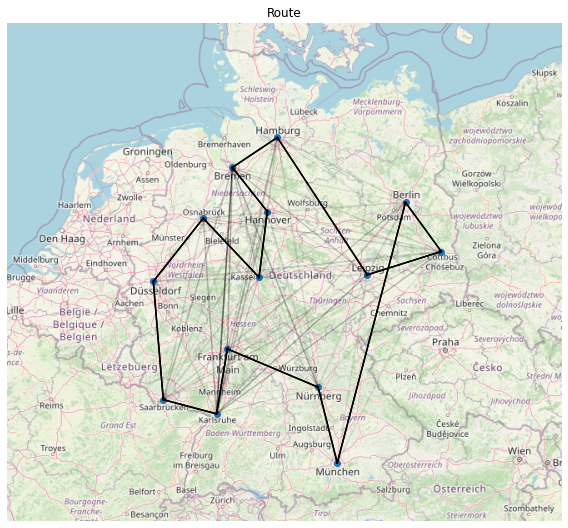

In [33]:
G = Germany()
C = AntColony(20, G, alpha=3.0, beta=3.0, rho=0.1)
ant_path, ant_length, pheromone = C(100)
G.visualize()

RUN TIME: 112.9 sec


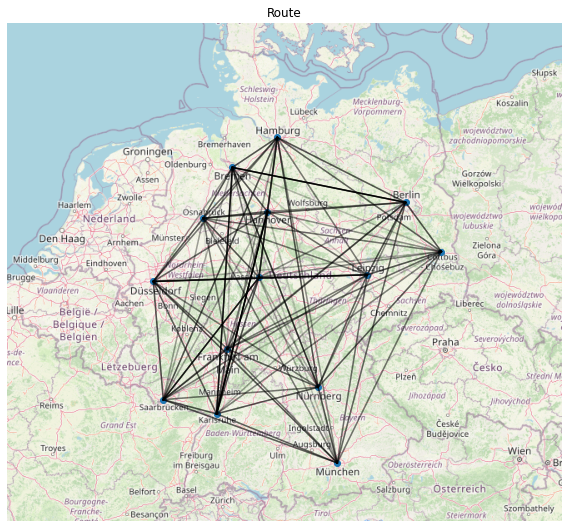

In [45]:
G = Germany()
C = AntColony(20, G, alpha=3.0, beta=3.0, rho=0.1, minmax=True)
ant_path, ant_length, pheromone = C(500)
G.visualize()

### Task 2: Implement the Min-Max Ant System
It is another improvement and newer than Ant Colony System. It is not a lot of work to implement Min-Max Ant System since it is only different in the way the update of the pheronome happens, for more [information](http://www.scholarpedia.org/article/Ant_colony_optimization#MAX_MIN_ant_system). You can switch to MinMax by changing the minmax parameter to True.

Hint for the minimal limit, as mentioned by [the authors of the Min-Max Ant System](https://www.gta.ufrj.br/ensino/cpe717-2011/stutzle97-icec.pdf):

"As we use a lower min-limit, the probability that a specific edge is chosen may become very small, but will be still greater than zero"

### Task 3:
1. Report the results of Ant Colony and Min Max System
2. Change the values of the number of ants and evaporation rate, and report the results as well.